<a href="https://colab.research.google.com/github/kotosham/sleep-stages/blob/main/MODELS_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download and install libraries

In [1]:
! pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 23.4 MB/s eta 0:00:00


In [78]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import os
import random

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch.utils.data import ConcatDataset

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score

# Initialization

Data

In [97]:
columns_to_read = ['1 LDF', '1 T', '1 A365', '1 A460', 'Sleep stages']

columns_dtype = {
    columns_to_read[0]:  'float32',
    columns_to_read[1]:  'float32',
    columns_to_read[2]:  'float32',
    columns_to_read[3]:  'float32',
    columns_to_read[-1]: 'int16',
 }

t_lower_bound = 35
big_file_no = 3
L_lower_threshold = 0
L_upper_threshold = 60
t_lower_threshold = 34

# Dictionary to map strings to integers
replacement_dict = {
    'W' : 0,
    'N2': 1,
    'N3': 1,
    'R' : 1
}

fragment_length = 400
num_samples = 4000
batch_size = 100
num_folds = 2
label_smoothing = 0

Model

In [98]:
num_features = len(columns_to_read) - 1
num_classes = 2

# Initialize the model
input_size = fragment_length * num_features  # Assuming 2 features per fragment
hidden_size = 50

lr = 0.001
n_epochs = 100

# Supplementary functions

Pre-processing of table data

In [81]:
def df_clean(df, replacement_dict, columns_to_read=columns_to_read):
  # delete rows with nan values in a column
  df = df.dropna()
  # LDF
  df = df[df[columns_to_read[0]] > L_lower_threshold]
  df = df[df[columns_to_read[0]] < L_upper_threshold]
  # Temperature
  df = df[df[columns_to_read[1]] > t_lower_threshold]
  # the last column is for labels
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)
  return df

def change_dtypes(df, columns_dtype):
  df = df.astype(columns_dtype)
  return df

In [82]:
def plot_batch_features(features, targets, batch_idx):
    """
    Plots the features of a batch and uses the labels as captions.

    Args:
        features (torch.Tensor): The features tensor of shape (batch_size, num_features).
        targets (torch.Tensor): The targets tensor of shape (batch_size,).
        batch_idx (int): The index of the batch.
    """
    batch_size = features.shape[0]
    num_features = features.shape[1]

    fig, axes = plt.subplots(1, batch_size, figsize=(3 * batch_size, 3))

    if batch_size == 1:
        axes = [axes]  # Ensure axes is a list if batch_size is 1

    for i in range(batch_size):
        ax = axes[i]
        ax.plot(features[i].cpu().numpy())
        ax.set_title(f'Batch {batch_idx + 1}, Sample {i + 1}, Label: {targets[i].item()}')
        ax.set_xlabel('Feature Index')
        ax.set_ylabel('Feature Value')

    plt.tight_layout()
    plt.show()

In [83]:
def vis_data(df, columns_to_read=columns_to_read):
    num_columns = len(columns_to_read)
    fig, axes = plt.subplots(1, num_columns, figsize=(5 * num_columns, 4))

    for k, column in enumerate(columns_to_read):
        # Гистограмма с KDE
        sns.histplot(df[column], kde=True, ax=axes[k])
        axes[k].set_title(f'Distribution of {column}')
        axes[k].set_xlabel(column)
        axes[k].set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Download data

In [84]:
# GitHub repository URL
repo_url = "https://github.com/kotosham/sleep-stages"

# Raw files URLs
download_files = ['1.csv', '2.csv', '3-1.csv', '3-2.csv',
                  '4.csv', '5.csv', '6.csv', '7.csv']
# files_with_subfiles = ['3']

for i in download_files:
  file_url = f"{repo_url}/raw/main/{i}"
  # Download the file
  response = requests.get(file_url)
  # Check if the request was successful
  if response.status_code == 200:
      # Save the content to a local file
      with open(i, "wb") as file:
          file.write(response.content)
  else:
      print(f"Failed to download the file. Status code: {response.status_code}")

Concatinate parts of a big file

In [99]:
dfs = []
df_3_1 = pd.read_csv('3-1.csv', usecols=columns_to_read)
dfs.append(df_3_1)
df_3_2 = pd.read_csv('3-2.csv', usecols=columns_to_read)
dfs.append(df_3_2)
df3 = pd.concat(dfs, ignore_index=True)
df3 = df_clean(df3,replacement_dict=replacement_dict)
df3 = change_dtypes(df3, columns_dtype)
print(df3.head())

    1 LDF    1 T  1 A365  1 A460  Sleep stages
12   14.3  34.57   103.0    22.0             0
13   14.3  34.57   103.0    22.0             0
14   14.3  34.57   103.0    22.0             0
15   14.3  34.57   103.0    22.0             0
16   17.1  34.57   103.0    22.0             0


<ipython-input-81-bdc82fe88d1e>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


Collect all the files into a list of data frames

In [100]:
num_volunteers = (len(download_files) - 1)
files = [1]*num_volunteers
for i in range(num_volunteers):
  if i + 1 != big_file_no:
    print(i)

    try:
        f"{repo_url}/raw/main/{i}"
        files[i] = pd.read_csv(f"{i+1}.csv", usecols=columns_to_read)
        #df_temp = pd.read_csv(f"{i+1}.csv")
        missing_columns = [col for col in columns_to_read if col not in files[i].columns]

        if missing_columns:
            print(f"Missing columns in file {i+1}: {missing_columns}")
            continue

    except ValueError as e:
            print(f"Error loading file {i + 1}: {e}")
            continue

    files[i] = df_clean(files[i],replacement_dict=replacement_dict)
    files[i] = change_dtypes(files[i], columns_dtype)
files[big_file_no - 1] = df3

0
1


<ipython-input-81-bdc82fe88d1e>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


3
4
Error loading file 5: Usecols do not match columns, columns expected but not found: ['1 A365', '1 A460']
5


<ipython-input-81-bdc82fe88d1e>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


6


<ipython-input-100-ef4527bb75da>:9: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  files[i] = pd.read_csv(f"{i+1}.csv", usecols=columns_to_read)


In [101]:
indices_to_keep = [0, 2, 3]
filtered_files = [files[i] for i in indices_to_keep]

files = filtered_files

for i, df in enumerate(files):
    print(f"DataFrame {i}:")
    print(df.head())

DataFrame 0:
         1 LDF    1 T  1 A365  1 A460  Sleep stages
664  18.400000  34.02    98.0    60.0             0
665  18.400000  34.02    98.0    60.0             0
666  18.400000  34.02    98.0    60.0             0
667  18.400000  34.02    98.0    60.0             0
668  22.799999  34.02    98.0    60.0             0
DataFrame 1:
    1 LDF    1 T  1 A365  1 A460  Sleep stages
12   14.3  34.57   103.0    22.0             0
13   14.3  34.57   103.0    22.0             0
14   14.3  34.57   103.0    22.0             0
15   14.3  34.57   103.0    22.0             0
16   17.1  34.57   103.0    22.0             0
DataFrame 2:
       1 LDF        1 T  1 A365  1 A460  Sleep stages
0  24.700001  36.459999   131.0    64.0             0
1  24.700001  36.459999   131.0    64.0             0
2  24.700001  36.459999   131.0    64.0             0
3  24.700001  36.459999   131.0    64.0             0
4  24.100000  36.459999   131.0    64.0             0


Means and variances

In [102]:
alldf = pd.concat(files, axis=0)
features = alldf[columns_to_read[:-1]].values
means = features.mean(axis=0)
stds = features.std(axis=0)
del[alldf, features]
means, stds

(array([ 26.904963,  37.47843 , 143.96387 ,  43.305584], dtype=float32),
 array([ 7.3709464 ,  0.78735936, 38.824425  , 10.07851   ], dtype=float32))

Visualize all the files

Volunteer 1
Number of samples 166627


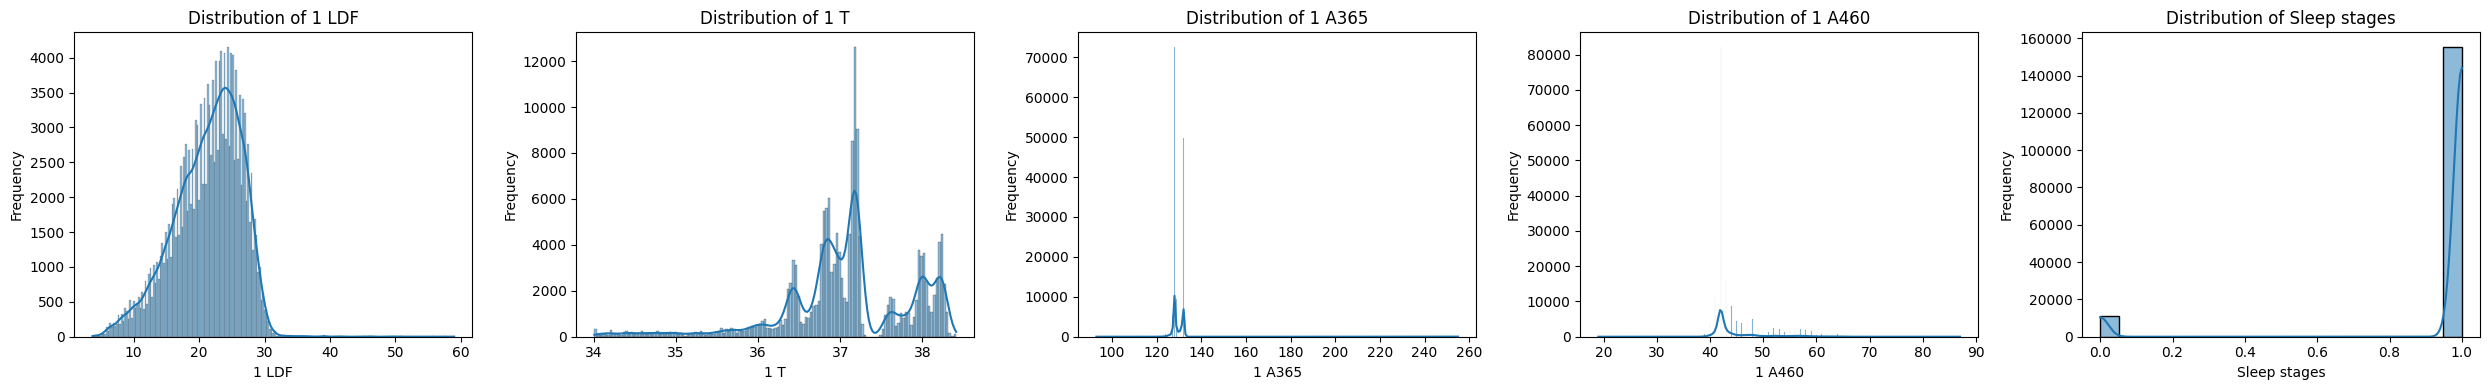

Volunteer 2
Number of samples 265936


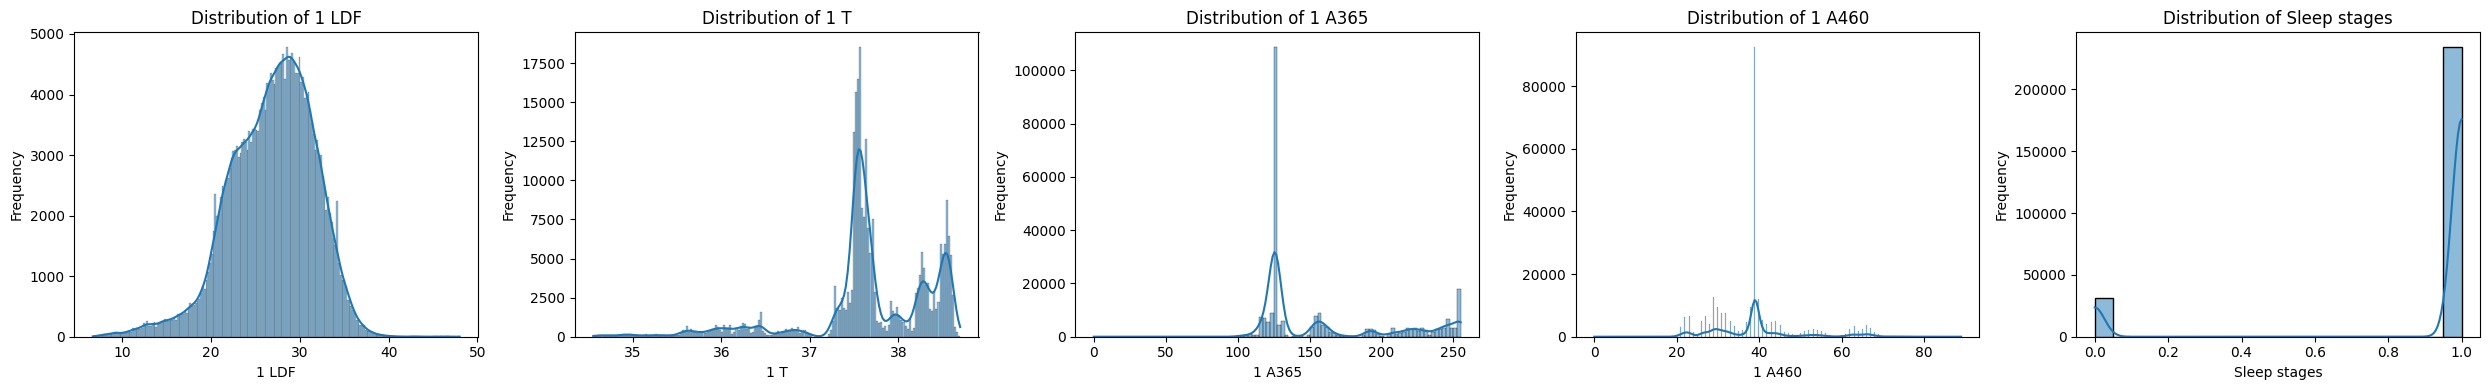

Volunteer 3
Number of samples 101844


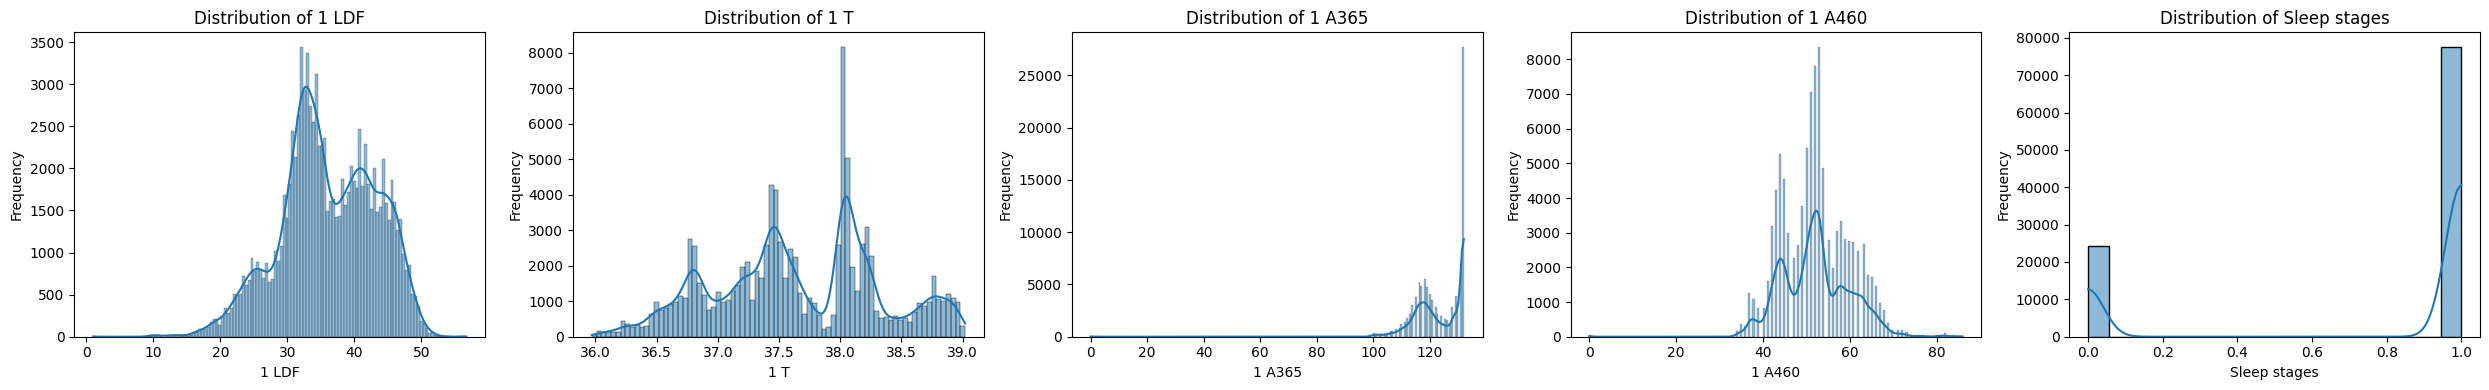

In [89]:
for i in range(num_volunteers-4):
  print(f'Volunteer {i+1}')
  print(f'Number of samples {len(files[i])}')
  vis_data(files[i])

In [90]:
files[1]

1 LDF    1 T  1 A365  1 A460  Sleep stages
12      14.300000  34.57   103.0    22.0             0
13      14.300000  34.57   103.0    22.0             0
14      14.300000  34.57   103.0    22.0             0
15      14.300000  34.57   103.0    22.0             0
16      17.100000  34.57   103.0    22.0             0
...           ...    ...     ...     ...           ...
527550  22.400000  38.57   143.0    26.0             1
527551  22.799999  38.57   143.0    26.0             1
527552  22.799999  38.57   143.0    26.0             1
527553  22.799999  38.57   143.0    26.0             1
527554  22.799999  38.57   143.0    26.0             1

[265936 rows x 5 columns]

# Dataset, dataloader, model, and training procedure

In [103]:
class FragmentDataset(Dataset):
    def __init__(self, dataframe, fragment_length, means, stds, num_samples):
        #self.dataframe = dataframe
        self.dataframe = dataframe.sort_values(by=dataframe.columns[-1])  # Sort by class
        self.fragment_length = fragment_length
        self.means = means
        self.stds = stds
        self.num_samples = num_samples
        self.data = self.load_data()

    def load_data(self):
        data = []
        class_column = self.dataframe.columns[-1]
        unique_classes = self.dataframe[class_column].unique()

        for _ in range(self.num_samples):
            selected_class = random.choice(unique_classes)
            class_data = self.dataframe[self.dataframe[class_column] == selected_class]
            if len(class_data) < self.fragment_length:
                continue  # Пропускаем, если недостаточно данных для фрагмента

            start_idx = random.randint(0, len(class_data) - self.fragment_length)
            fragment = class_data.iloc[start_idx:start_idx + self.fragment_length].values
            fragment = (fragment[:, :-1] - self.means) / self.stds
            fragment = fragment.flatten(order='F')  # Flatten the fragment to 1D
            fragment = torch.tensor(fragment, dtype=torch.float32)
            label = torch.tensor(int(selected_class), dtype=torch.long)
            fragment = fragment.flatten()
            data.append((fragment, label))

        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        fragment, label = self.data[idx]
        return fragment, label


class FragmentDataModule(pl.LightningDataModule):
    def __init__(self, files, means, stds, fragment_length=fragment_length, num_samples=num_samples, batch_size=batch_size, num_folds=num_folds):
        self.files = files
        self.fragment_length = fragment_length
        self.means = means
        self.stds = stds
        self.num_samples = num_samples
        self.batch_size = batch_size
        self.num_folds = num_folds

    def setup(self, stage=None):
        self.datasets = [FragmentDataset(df, self.fragment_length, self.means, self.stds, self.num_samples) for df in self.files]
        self.kfold = KFold(n_splits=self.num_folds)

    def train_dataloader(self, train_indices):
        train_datasets = [self.datasets[i] for i in train_indices]
        return DataLoader(torch.utils.data.ConcatDataset(train_datasets), batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self, val_indices):
        val_datasets = [self.datasets[i] for i in val_indices]
        return DataLoader(torch.utils.data.ConcatDataset(val_datasets), batch_size=self.batch_size)

    def test_dataloader(self, test_index):
        test_dataset = self.datasets[test_index]
        return DataLoader(test_dataset, batch_size=self.batch_size)

In [92]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class MLPModel(pl.LightningModule):
    def __init__(self, input_size, hidden_size, num_classes, class_weights=None, label_smoothing=0.0):
        super(MLPModel, self).__init__()
        self.model = MLP(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes)

        if class_weights is not None:
            self.criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=label_smoothing)
        else:
            self.criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)

        loss = self.criterion(outputs, y)

        preds = torch.argmax(outputs, dim=1)

        acc = accuracy_score(y.cpu(), preds.cpu())

        self.log('train_loss', loss)
        self.log('train_acc', acc)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)

        loss = self.criterion(outputs, y)
        preds = torch.argmax(outputs, dim=1)
        acc = accuracy_score(y.cpu(), preds.cpu())

        self.log('val_loss', loss)
        self.log('val_acc', acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        loss = self.criterion(outputs, y)

        self.log('test_loss', loss)

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=lr)

# Бинарная классификация

In [104]:
data_module = FragmentDataModule(files, means, stds)
data_module.setup()

### Decision Tree Model

In [118]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

In [119]:
test_accuracies = []

param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch
        X_train.append(features.numpy())  # Признаки
        y_train.append(labels.numpy())     # Метки

    X_train = np.vstack(X_train)
    y_train = np.concatenate(y_train)

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch
        X_val.append(features.numpy())  # Признаки
        y_val.append(labels.numpy())     # Метки

    X_val = np.vstack(X_val)
    y_val = np.concatenate(y_val)

    model_dt = DecisionTreeClassifier()
    grid_search = GridSearchCV(model_dt, param_grid, cv=3)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Валидация модели на валидационном наборе
    val_preds = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch
        X_test.append(features.numpy())  # Признаки
        y_test.append(labels.numpy())     # Метки

    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    # Тестирование модели на тестовом наборе
    test_preds = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_accuracies.append(test_accuracy)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

Fold 1
Validation Accuracy for Fold 1: 0.7695
Test Accuracy for Fold 1: 0.6685
Fold 2
Validation Accuracy for Fold 2: 0.6470
Test Accuracy for Fold 2: 0.5108
Mean Test Accuracy: 0.5896


### SVM model

In [120]:
from sklearn.svm import SVC

In [121]:
test_accuracies = []

for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch
        X_train.append(features.numpy())  # Признаки
        y_train.append(labels.numpy())     # Метки

    X_train = np.vstack(X_train)
    y_train = np.concatenate(y_train)

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch
        X_val.append(features.numpy())  # Признаки
        y_val.append(labels.numpy())     # Метки

    X_val = np.vstack(X_val)
    y_val = np.concatenate(y_val)

    model_svm = SVC(kernel='rbf', C=1.0, gamma='scale')

    model_svm.fit(X_train, y_train)

    # Валидация модели на валидационном наборе
    val_preds = model_svm.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch
        X_test.append(features.numpy())  # Признаки
        y_test.append(labels.numpy())     # Метки

    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    # Тестирование модели на тестовом наборе
    test_preds = model_svm.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_accuracies.append(test_accuracy)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

Fold 1
Validation Accuracy for Fold 1: 0.7420
Test Accuracy for Fold 1: 0.6600
Fold 2
Validation Accuracy for Fold 2: 0.5185
Test Accuracy for Fold 2: 0.5282
Mean Test Accuracy: 0.5941


### MLP model

In [122]:
test_accuracies = []

for fold, (train_indices, val_index) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')
    print(train_indices)
    print(val_index)

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_index)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    y_train = []
    for batch in train_loader:
        _, labels = batch
        y_train.extend(labels.numpy())

    # Вычисляем веса классов
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

    # Инициализация модели MLP для текущего фолда
    model_mlp = MLPModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes, class_weights=class_weights_tensor,label_smoothing=label_smoothing)
    model_mlp.to(device)  # Перемещаем модель на GPU

    logger = TensorBoardLogger("logs", name="mlp_model")
    trainer = Trainer(max_epochs=n_epochs, callbacks=[ModelCheckpoint(monitor='val_loss')], logger=logger)

    # Обучение модели на текущем фолде
    trainer.fit(model_mlp, train_dataloaders=train_loader, val_dataloaders=val_loader)

    val_acc = trainer.callback_metrics['val_acc'].item()
    print(f'Validation Accuracy for Fold {fold + 1}: {val_acc:.4f}')

    test_index = len(data_module.datasets)-1

    test_loader = data_module.test_dataloader(test_index)

    # Load the best model for this fold
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = MLPModel.load_from_checkpoint(best_model_path,
                                               input_size=input_size,
                                               hidden_size=hidden_size,
                                               num_classes=num_classes,
                                               strict=False)
    best_model.to(device)  # Перемещаем лучшую модель на GPU

    # Тестирование лучшей модели на тестовом наборе
    y_true = []
    y_pred = []

    for batch in test_loader:
        x, y = batch
        x = x.to(device)  # Перемещаем входные данные на GPU
        outputs = best_model(x)  # Используем лучшую модель
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())
        print(f'Predictions: {preds.cpu().numpy()}')
        print(f'True Labels: {y.tolist()}')

    accuracy = accuracy_score(y_true, y_pred)
    test_accuracies.append(accuracy)
    print(f'Test Accuracy for Fold {fold + 1}: {accuracy:.4f}')

# Вычисление средних значений точностей
mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 80.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
80.2 K    Trainable params
0         Non-trainable params
80.2 K    Total params
0.321     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Fold 1
[1]
[0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


Validation Accuracy for Fold 1: 0.6607
Predictions: [1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0
 0 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 0
 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 1 1 1]
True Labels: [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1]
Predictions: [0 1 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0
 1 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0
 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 1 0 1 0]
True Labels: [0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 80.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
80.2 K    Trainable params
0         Non-trainable params
80.2 K    Total params
0.321     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Validation Accuracy for Fold 2: 0.3877
Predictions: [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 0 0 1 0 1 0 1 0
 0 0 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0
 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0]
True Labels: [1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1]
Predictions: [0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0
 0 1 0 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
True Labels: [0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


### Gradient Boosting

In [123]:
!pip install xgboost

In [124]:
from xgboost import XGBClassifier

In [125]:
test_accuracies = []

for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch
        X_train.append(features.numpy())  # Признаки
        y_train.append(labels.numpy())     # Метки

    X_train = np.vstack(X_train)
    y_train = np.concatenate(y_train)

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch
        X_val.append(features.numpy())  # Признаки
        y_val.append(labels.numpy())     # Метки

    X_val = np.vstack(X_val)
    y_val = np.concatenate(y_val)

    model_gb = XGBClassifier(
                            n_estimators=300,
                            learning_rate=lr,
                            max_depth=5,
                            random_state=42,
                            tree_method='gpu_hist'
                            )

    model_gb.fit(X_train, y_train)

    # Валидация модели на валидационном наборе
    val_preds = model_gb.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch
        X_test.append(features.numpy())  # Признаки
        y_test.append(labels.numpy())     # Метки

    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    # Тестирование модели на тестовом наборе
    test_preds = model_gb.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_accuracies.append(test_accuracy)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

Fold 1


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:39] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.


Validation Accuracy for Fold 1: 0.6522
Test Accuracy for Fold 1: 0.6960
Fold 2


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:19:48] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 2: 0.6480
Test Accuracy for Fold 2: 0.5108
Mean Test Accuracy: 0.6034


# Многоклассовая классификация

In [126]:
replacement_dict = {
    'W': 0,
    'N2': 1,
    'N3': 1,
    'R': 2
}

num_classes = 3

In [128]:
dfs = []
df_3_1 = pd.read_csv('3-1.csv', usecols=columns_to_read)
dfs.append(df_3_1)
df_3_2 = pd.read_csv('3-2.csv', usecols=columns_to_read)
dfs.append(df_3_2)
df3 = pd.concat(dfs, ignore_index=True)
df3 = df_clean(df3, replacement_dict=replacement_dict)
df3 = change_dtypes(df3, columns_dtype)

files = [1]*num_volunteers
for i in range(num_volunteers):
  if i + 1 != big_file_no:
    print(i)

    try:
        f"{repo_url}/raw/main/{i}"
        files[i] = pd.read_csv(f"{i+1}.csv", usecols=columns_to_read)
        #df_temp = pd.read_csv(f"{i+1}.csv")
        missing_columns = [col for col in columns_to_read if col not in files[i].columns]

        if missing_columns:
            print(f"Missing columns in file {i+1}: {missing_columns}")
            continue

    except ValueError as e:
            print(f"Error loading file {i + 1}: {e}")
            continue  # Пропускаем файл при ошибке

    files[i] = df_clean(files[i],replacement_dict=replacement_dict)
    files[i] = change_dtypes(files[i], columns_dtype)
files[big_file_no - 1] = df3

<ipython-input-81-bdc82fe88d1e>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


0


<ipython-input-81-bdc82fe88d1e>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


1
3


<ipython-input-81-bdc82fe88d1e>:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[columns_to_read[-1]] = df[columns_to_read[-1]].replace(replacement_dict)


4
Error loading file 5: Usecols do not match columns, columns expected but not found: ['1 A365', '1 A460']
5
6


<ipython-input-128-6867b6ac3196>:17: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  files[i] = pd.read_csv(f"{i+1}.csv", usecols=columns_to_read)


In [129]:
indices_to_keep = [0, 2, 3]
filtered_files = [files[i] for i in indices_to_keep]

files = filtered_files

for i, df in enumerate(files):
    print(f"DataFrame {i}:")
    print(df.head())

DataFrame 0:
         1 LDF    1 T  1 A365  1 A460  Sleep stages
664  18.400000  34.02    98.0    60.0             0
665  18.400000  34.02    98.0    60.0             0
666  18.400000  34.02    98.0    60.0             0
667  18.400000  34.02    98.0    60.0             0
668  22.799999  34.02    98.0    60.0             0
DataFrame 1:
    1 LDF    1 T  1 A365  1 A460  Sleep stages
12   14.3  34.57   103.0    22.0             0
13   14.3  34.57   103.0    22.0             0
14   14.3  34.57   103.0    22.0             0
15   14.3  34.57   103.0    22.0             0
16   17.1  34.57   103.0    22.0             0
DataFrame 2:
       1 LDF        1 T  1 A365  1 A460  Sleep stages
0  24.700001  36.459999   131.0    64.0             0
1  24.700001  36.459999   131.0    64.0             0
2  24.700001  36.459999   131.0    64.0             0
3  24.700001  36.459999   131.0    64.0             0
4  24.100000  36.459999   131.0    64.0             0


Volunteer 1
Number of samples 166627


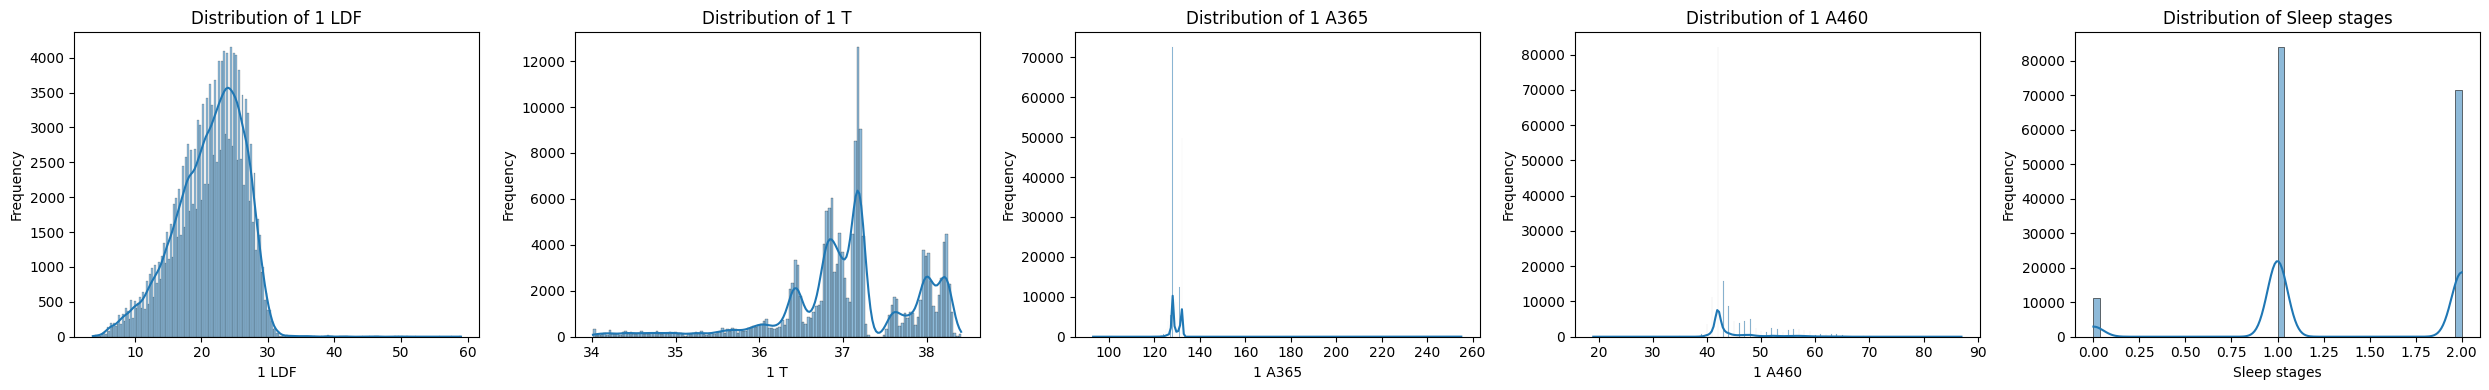

Volunteer 2
Number of samples 265936


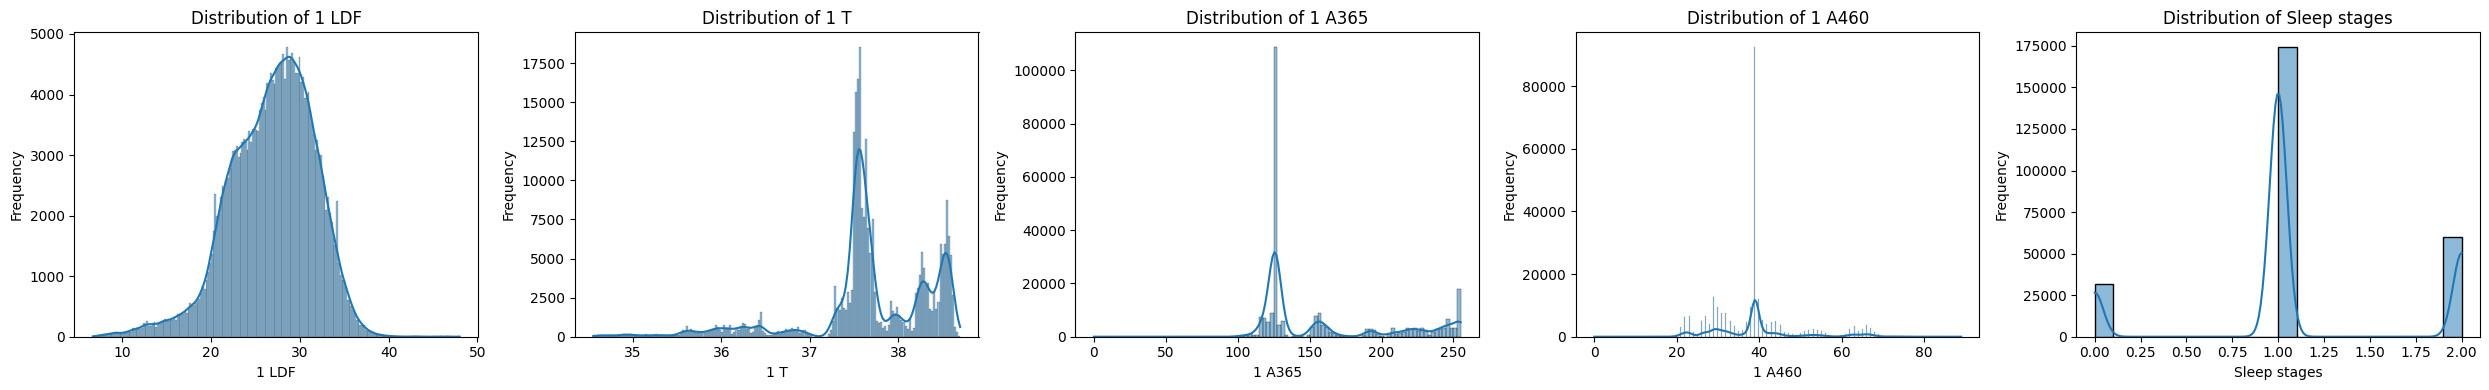

Volunteer 3
Number of samples 101844


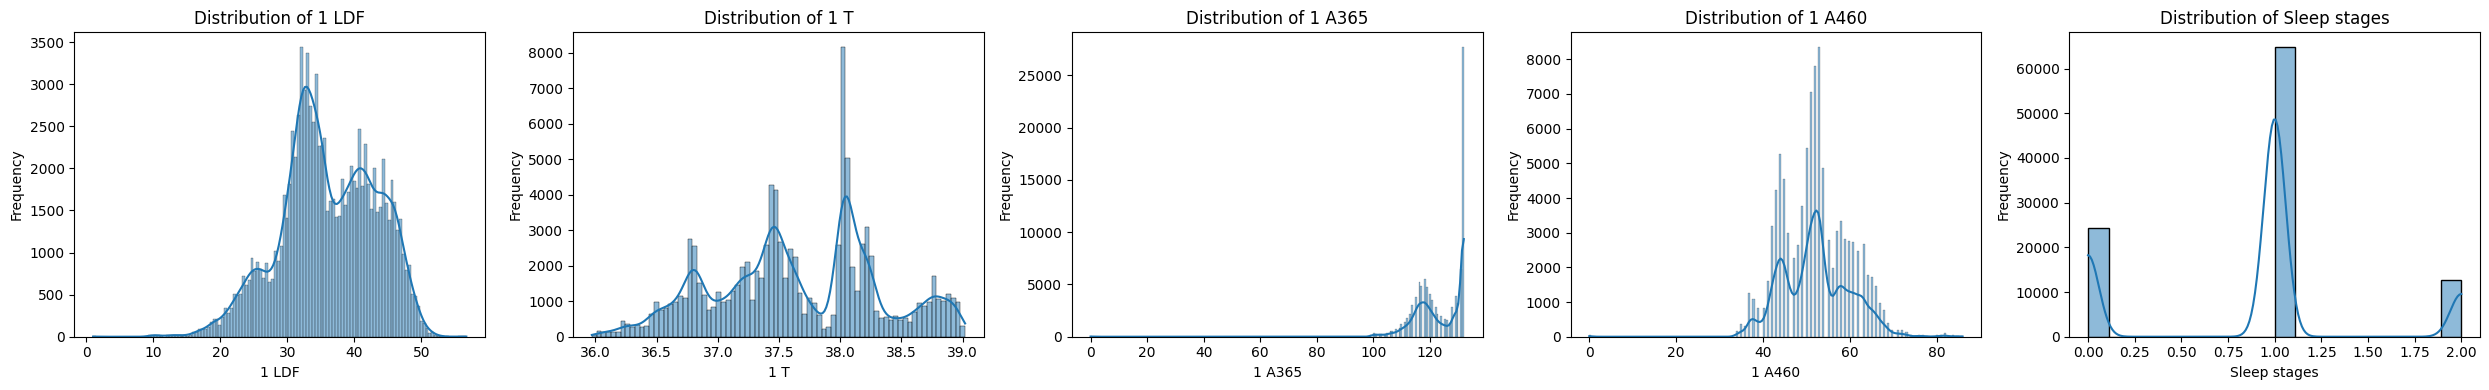

In [131]:
for i in range(num_volunteers-4):
  print(f'Volunteer {i+1}')
  print(f'Number of samples {len(files[i])}')
  vis_data(files[i])

In [132]:
data_module = FragmentDataModule(files,means,stds)
data_module.setup()

In [133]:
if torch.cuda.is_available():
    device = torch.device("cuda")  # Использовать GPU
    print("GPU is available")
else:
    device = torch.device("cpu")  # Использовать CPU
    print("GPU is not available, using CPU")

GPU is available


### Desicion Tree

In [134]:
test_accuracies = []

param_grid = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch
        X_train.append(features.numpy())  # Признаки
        y_train.append(labels.numpy())     # Метки

    X_train = np.vstack(X_train)  # Объединяем в двумерный массив
    y_train = np.concatenate(y_train)  # Объединяем метки в одномерный массив

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch
        X_val.append(features.numpy())  # Признаки
        y_val.append(labels.numpy())     # Метки

    X_val = np.vstack(X_val)
    y_val = np.concatenate(y_val)

    # Инициализация и обучение модели дерева решений с настройкой гиперпараметров
    model_dt = DecisionTreeClassifier()
    grid_search = GridSearchCV(model_dt, param_grid, cv=3)

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_

    # Валидация модели на валидационном наборе
    val_preds = best_model.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch
        X_test.append(features.numpy())  # Признаки
        y_test.append(labels.numpy())     # Метки

    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    # Тестирование модели на тестовом наборе
    test_preds = best_model.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_accuracies.append(test_accuracy)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

Fold 1
Validation Accuracy for Fold 1: 0.5540
Test Accuracy for Fold 1: 0.3430
Fold 2
Validation Accuracy for Fold 2: 0.5547
Test Accuracy for Fold 2: 0.1500
Mean Test Accuracy: 0.2465


### SVM

In [135]:
test_accuracies = []

for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch
        X_train.append(features.numpy())  # Признаки
        y_train.append(labels.numpy())     # Метки

    X_train = np.vstack(X_train)
    y_train = np.concatenate(y_train)

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch
        X_val.append(features.numpy())  # Признаки
        y_val.append(labels.numpy())     # Метки

    X_val = np.vstack(X_val)
    y_val = np.concatenate(y_val)

    model_svm = SVC(kernel='rbf', C=1.0, gamma='scale')

    model_svm.fit(X_train, y_train)

    # Валидация модели на валидационном наборе
    val_preds = model_svm.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch
        X_test.append(features.numpy())  # Признаки
        y_test.append(labels.numpy())     # Метки

    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    # Тестирование модели на тестовом наборе
    test_preds = model_svm.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_accuracies.append(test_accuracy)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

Fold 1
Validation Accuracy for Fold 1: 0.5675
Test Accuracy for Fold 1: 0.4195
Fold 2
Validation Accuracy for Fold 2: 0.4878
Test Accuracy for Fold 2: 0.2542
Mean Test Accuracy: 0.3369


### MLP

In [136]:
test_accuracies = []

for fold, (train_indices, val_index) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_index)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    y_train = []
    for batch in train_loader:
        _, labels = batch
        y_train.extend(labels.numpy())

    # Вычисляем веса классов
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

    # Инициализация модели MLP для текущего фолда
    model_mlp = MLPModel(input_size=input_size, hidden_size=hidden_size, num_classes=num_classes, class_weights=class_weights_tensor,label_smoothing=label_smoothing)
    model_mlp.to(device)  # Перемещаем модель на GPU

    logger = TensorBoardLogger("logs", name="mlp_model")
    trainer = Trainer(max_epochs=n_epochs, callbacks=[ModelCheckpoint(monitor='val_loss')], logger=logger)

    # Обучение модели на текущем фолде
    trainer.fit(model_mlp, train_dataloaders=train_loader, val_dataloaders=val_loader)

    val_acc = trainer.callback_metrics['val_acc'].item()
    print(f'Validation Accuracy for Fold {fold + 1}: {val_acc:.4f}')

    test_index = len(data_module.datasets)-1

    test_loader = data_module.test_dataloader(test_index)
    #test_results = trainer.test(best_model, test_loader)

    # Load the best model for this fold
    best_model_path = trainer.checkpoint_callback.best_model_path
    best_model = MLPModel.load_from_checkpoint(best_model_path,
                                               input_size=input_size,
                                               hidden_size=hidden_size,
                                               num_classes=num_classes,
                                               strict=False)
    best_model.to(device)  # Перемещаем лучшую модель на GPU

    # Тестирование лучшей модели на тестовом наборе
    y_true = []
    y_pred = []

    for batch in test_loader:
        x, y = batch
        x = x.to(device)  # Перемещаем входные данные на GPU
        outputs = best_model(x)  # Используем лучшую модель
        preds = torch.argmax(outputs, dim=1)
        y_true.extend(y.tolist())
        y_pred.extend(preds.tolist())
        print(f'Predictions: {preds.cpu().numpy()}')
        print(f'True Labels: {y.tolist()}')

    accuracy = accuracy_score(y_true, y_pred)
    test_accuracies.append(accuracy)
    print(f'Test Accuracy for Fold {fold + 1}: {accuracy:.4f}')

mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 80.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
80.2 K    Trainable params
0         Non-trainable params
80.2 K    Total params
0.321     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Fold 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


Validation Accuracy for Fold 1: 0.5055
Predictions: [0 0 0 1 2 0 0 1 1 0 0 1 0 0 0 0 1 1 0 0 0 2 0 1 1 0 0 1 0 0 1 0 0 1 2 1 0
 1 0 0 0 1 1 0 2 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 2 0 0 0 0 0 0 1 1 0
 0 1 0 1 0 1 0 1 1 1 1 0 0 0 0 2 2 1 0 0 0 0 2 1 0 0]
True Labels: [0, 0, 0, 1, 1, 1, 2, 2, 1, 0, 2, 2, 0, 0, 0, 2, 1, 2, 1, 1, 0, 1, 2, 2, 2, 2, 2, 1, 1, 0, 1, 2, 0, 2, 1, 1, 0, 1, 0, 0, 1, 1, 2, 1, 1, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 0, 2, 1, 0, 2, 2, 0, 2, 2, 1, 0, 2, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 2, 2, 0, 0, 1, 1, 0, 2]
Predictions: [0 0 0 0 1 1 0 2 0 1 0 0 0 2 0 0 2 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0
 0 1 0 0 1 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 2 2 2 0 2 1 0 2
 1 1 0 0 1 0 0 0 0 0 0 1 0 2 0 0 0 0 0 0 0 2 1 0 0 0]
True Labels: [0, 1, 0, 0, 1, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 2, 1, 2, 2, 2, 0, 2, 1, 0, 1, 2, 0, 0, 0, 1, 2, 0, 1, 1, 2, 1, 1, 1, 2, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 0, 2, 1

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model     | MLP              | 80.2 K | train
1 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
80.2 K    Trainable params
0         Non-trainable params
80.2 K    Total params
0.321     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Validation Accuracy for Fold 2: 0.2668
Predictions: [0 0 0 0 0 2 2 2 2 0 2 2 0 0 0 2 0 2 0 2 0 0 2 2 2 2 2 2 2 0 2 2 0 2 0 2 0
 2 0 0 0 2 2 0 0 2 0 2 2 2 0 0 2 2 2 0 2 2 2 0 0 0 0 0 2 0 0 2 2 2 0 2 2 0
 2 2 0 2 2 2 0 2 2 2 2 0 2 2 0 2 0 2 2 2 0 0 2 2 0 2]
True Labels: [0, 0, 0, 1, 1, 1, 2, 2, 1, 0, 2, 2, 0, 0, 0, 2, 1, 2, 1, 1, 0, 1, 2, 2, 2, 2, 2, 1, 1, 0, 1, 2, 0, 2, 1, 1, 0, 1, 0, 0, 1, 1, 2, 1, 1, 2, 0, 2, 2, 2, 0, 1, 2, 2, 2, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 2, 2, 0, 2, 1, 0, 2, 2, 0, 2, 2, 1, 0, 2, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 2, 2, 0, 0, 1, 1, 0, 2]
Predictions: [0 0 0 0 2 2 2 2 2 2 2 2 0 0 0 2 0 2 2 2 0 2 0 0 0 2 0 0 0 2 2 0 2 2 2 0 0
 0 2 2 0 2 0 2 0 2 0 2 0 0 0 0 0 2 2 0 2 2 0 0 2 2 0 0 0 2 0 0 0 0 0 2 0 2
 2 2 2 0 2 0 0 0 2 2 0 2 2 0 0 2 2 0 2 0 2 0 2 2 0 2]
True Labels: [0, 1, 0, 0, 1, 1, 2, 1, 2, 2, 2, 2, 0, 1, 0, 2, 1, 2, 2, 2, 0, 2, 1, 0, 1, 2, 0, 0, 0, 1, 2, 0, 1, 1, 2, 1, 1, 1, 2, 2, 0, 2, 0, 1, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 0, 2, 1

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.weight']


### Gradient Boosting

In [137]:
test_accuracies = []

for fold, (train_indices, val_indices) in enumerate(data_module.kfold.split(range(len(data_module.datasets)-1))):
    print(f'Fold {fold + 1}')

    train_loader = data_module.train_dataloader(train_indices)
    val_loader = data_module.val_dataloader(val_indices)

    X_train, y_train = [], []
    for batch in train_loader:
        features, labels = batch
        X_train.append(features.numpy())  # Признаки
        y_train.append(labels.numpy())     # Метки

    X_train = np.vstack(X_train)
    y_train = np.concatenate(y_train)

    X_val, y_val = [], []
    for batch in val_loader:
        features, labels = batch
        X_val.append(features.numpy())  # Признаки
        y_val.append(labels.numpy())     # Метки

    X_val = np.vstack(X_val)
    y_val = np.concatenate(y_val)

    model_gb = XGBClassifier(
                            n_estimators=300,
                            learning_rate=lr,
                            max_depth=5,
                            random_state=42,
                            tree_method='gpu_hist'
                            )

    model_gb.fit(X_train, y_train)

    # Валидация модели на валидационном наборе
    val_preds = model_gb.predict(X_val)
    val_accuracy = accuracy_score(y_val, val_preds)

    print(f'Validation Accuracy for Fold {fold + 1}: {val_accuracy:.4f}')

    test_index = len(data_module.datasets) - 1

    test_loader = data_module.test_dataloader(test_index)

    X_test, y_test = [], []
    for batch in test_loader:
        features, labels = batch
        X_test.append(features.numpy())  # Признаки
        y_test.append(labels.numpy())     # Метки

    X_test = np.vstack(X_test)
    y_test = np.concatenate(y_test)

    # Тестирование модели на тестовом наборе
    test_preds = model_gb.predict(X_test)
    test_accuracy = accuracy_score(y_test, test_preds)
    test_accuracies.append(test_accuracy)

    print(f'Test Accuracy for Fold {fold + 1}: {test_accuracy:.4f}')

mean_test_accuracy = np.mean(test_accuracies)
print(f'Mean Test Accuracy: {mean_test_accuracy:.4f}')

Fold 1


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:38] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 1: 0.4848
Test Accuracy for Fold 1: 0.4462
Fold 2


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:46] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:26:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Validation Accuracy for Fold 2: 0.5673
Test Accuracy for Fold 2: 0.1022
Mean Test Accuracy: 0.2742
